In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from bisect import bisect_left
import math
from sklearn.metrics import balanced_accuracy_score
from tqdm.notebook import tqdm
import uuid
from datetime import datetime
import tensorflow as tf
import time

In [ ]:
# Globals
EPOCHS = 100
BATCH_SIZE = 1024
NUM_WORKERS = 2
LR_DECAY = 0.95
LOSS_WEIGHTS = torch.tensor([2.0, 2.0, 1.0]) # torch.tensor([1.0, 1.0, 2.0])
SPLIT = [0.7, 0.15, 0.15]
TEST_WARMUP = 10
NUM_TESTS = 1000
learning_rate = 1e-2


MODEL_SAVE_DIR = "/content/drive/MyDrive/CS131FinalProject/Models"
HAND_TENSOR_DIR = "/content/drive/MyDrive/CS131FinalProject/ArticulationData"


"""
Note that I weight the 3 class which is for anything other then "E" and "X"
higher so that the model is more likely to predict it over the other two classes.
I do this to make it harder for players to make the the elemental gesture so
they will need some practice. I will train with evens weights as well to see if
model can predict the classes well
"""

'\nNote that I weight the 3 class which is for anything other then "E" and "X"\nhigher so that the model is more likely to predict it over the other two classes.\nI do this to make it harder for players to make the the elemental gesture so\nthey will need some practice. I will train with evens weights as well to see if\nmodel can predict the classes well\n'

In [ ]:
# Data
x_data = np.load(os.path.join(HAND_TENSOR_DIR, "x_tensor.npy"))
ax_data = np.load(os.path.join(HAND_TENSOR_DIR, "aug_x_tensor.npy"))
e_data = np.load(os.path.join(HAND_TENSOR_DIR, "e_tensor.npy"))
ae_data = np.load(os.path.join(HAND_TENSOR_DIR, "aug_e_tensor.npy"))
o_data = np.load(os.path.join(HAND_TENSOR_DIR, "other_tensor.npy"))
ao_data = np.load(os.path.join(HAND_TENSOR_DIR, "aug_other_tensor.npy"))

print(x_data.shape, e_data.shape, o_data.shape)
print(ax_data.shape, ae_data.shape, ao_data.shape)

(5370, 63) (5390, 63) (141536, 63)
(64440, 63) (64680, 63) (141536, 63)


In [ ]:
# Dataset tf.convert_to_tensor(numpy_array, dtype=float, name='tensor1')
class HandDataSet(Dataset):
  def __init__(self, data, labels):
    self.data = data
    self.labels = labels
  def __len__(self):
    return self.data.shape[0]
  def __getitem__(self, idx):
    return torch.from_numpy(self.data[idx]).to(torch.float32).squeeze(), torch.LongTensor([bisect_left(self.labels, idx)]).squeeze()

In [ ]:
def saveDataSet(dataset, dir, name):
  np.save(os.path.join(dir, str(name) + "indices"), dataset.indices)

In [ ]:
def loadDataSet(dir, names=["train", "val", "test"]):
  x_data = np.load(os.path.join(HAND_TENSOR_DIR, "x_tensor.npy"))
  ax_data = np.load(os.path.join(HAND_TENSOR_DIR, "aug_x_tensor.npy"))
  e_data = np.load(os.path.join(HAND_TENSOR_DIR, "e_tensor.npy"))
  ae_data = np.load(os.path.join(HAND_TENSOR_DIR, "aug_e_tensor.npy"))
  o_data = np.load(os.path.join(HAND_TENSOR_DIR, "other_tensor.npy"))
  ao_data = np.load(os.path.join(HAND_TENSOR_DIR, "aug_other_tensor.npy"))
  data = np.concatenate((x_data, ax_data, e_data, ae_data, o_data, ao_data), axis=0)
  x_size, e_size = x_data.shape[0] + ax_data.shape[0], e_data.shape[0] + ae_data.shape[0]
  labels = [x_size - 1, x_size + e_size - 1]
  train_indices = np.load(os.path.join(dir, names[0] + "indices.npy"))
  val_indices = np.load(os.path.join(dir, names[1] + "indices.npy"))
  test_indices = np.load(os.path.join(dir, names[2] + "indices.npy"))
  return HandDataSet(data, labels), train_indices, val_indices, test_indices

In [ ]:
# Dataloader
generator = torch.Generator().manual_seed(42)

data = np.concatenate((x_data, ax_data, e_data, ae_data, o_data, ao_data), axis=0)
x_size, e_size = x_data.shape[0] + ax_data.shape[0], e_data.shape[0] + ae_data.shape[0]
labels = [x_size - 1, x_size + e_size - 1]
train_data, val_data, test_data = random_split(HandDataSet(data, labels), SPLIT, generator=generator)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [ ]:
# Simple MLP Model
class HandMLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_size = 63
    self.hidden1_size = 64
    self.hidden2_size = 64
    self.hidden3_size = 32
    self.output_size = 3

    self.layer1 = nn.Linear(self.input_size, self.hidden1_size)
    self.layer2 = nn.Linear(self.hidden1_size, self.hidden2_size)
    self.layer3 = nn.Linear(self.hidden2_size, self.hidden3_size)
    self.output = nn.Linear(self.hidden3_size, self.output_size)

  def forward(self, x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = F.relu(self.layer3(x))
    x = self.output(x)
    return x

In [ ]:
model = HandMLP()
criterion = nn.CrossEntropyLoss(weight=LOSS_WEIGHTS)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: LR_DECAY)

In [ ]:
def get_balanced_acc(gt, y):
  y = np.argmin(y.numpy() * -1, axis=1)
  return balanced_accuracy_score(gt.numpy(), y)

In [ ]:
# Creating directory to save files to
train_id = (str(uuid.uuid4()) + str(datetime.now())).replace(" ", "_")
save_path = os.path.join(MODEL_SAVE_DIR, train_id)
os.mkdir(save_path)

saveDataSet(train_data, save_path, "train")
saveDataSet(val_data, save_path, "val")
saveDataSet(test_data, save_path, "test")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.train()

epoch_losses = []
epoch_train_bal_accs = []
epoch_val_bal_accs = []

# Training loop
best_bal_acc = 0
for epoch in tqdm(range(EPOCHS), desc=f"Training -- Best Acc = {round(best_bal_acc, 2)}"):
  epoch_loss, predictions, epoch_labels = 0, torch.tensor([]), torch.tensor([])
  for i, (inputs, labels) in enumerate(train_loader):

    # Move tensors to GPU
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      epoch_loss += loss
      predictions = torch.cat((predictions, outputs.squeeze()))
      epoch_labels = torch.cat((epoch_labels, labels.squeeze()))


  # Step the scheduler
  scheduler.step()
  epoch_train_bal_accs.append(get_balanced_acc(epoch_labels, predictions))
  epoch_losses.append(epoch_loss)
  print(f"Epoch {epoch+1} complete! Learning Rate: {scheduler.get_last_lr()[0]} Loss: {epoch_loss} Accuracy: {epoch_train_bal_accs[-1]}")

  # Eval the validation set
  with torch.no_grad():
    val_loss, val_predictions, val_labels = 0, torch.tensor([]), torch.tensor([])
    for i, (inputs, labels) in enumerate(val_loader):
      outputs = model(inputs)
      val_loss += criterion(outputs, labels)
      val_predictions = torch.cat((val_predictions, outputs.squeeze()))
      val_labels = torch.cat((val_labels, labels.squeeze()))

    epoch_val_bal_accs.append(get_balanced_acc(val_labels, val_predictions))
    if epoch_val_bal_accs[-1] > best_bal_acc:
      best_bal_acc = epoch_val_bal_accs[-1]
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': loss
          }, os.path.join(save_path, str(epoch)))

np.save(os.path.join(save_path, "loss.npy"), np.array(epoch_losses))
np.save(os.path.join(save_path, "train_acc.npy"), np.array(epoch_train_bal_accs))
np.save(os.path.join(save_path, "val_acc.npy"), np.array(epoch_val_bal_accs))
print('Training finished.')

Training -- Best Acc = 0:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 complete! Learning Rate: 0.0095 Loss: 168.35690307617188 Accuracy: 0.9376835452364932
Epoch 2 complete! Learning Rate: 0.009025 Loss: 48.198486328125 Accuracy: 0.9855738555500894
Epoch 3 complete! Learning Rate: 0.00857375 Loss: 35.997920989990234 Accuracy: 0.9892523856094296
Epoch 4 complete! Learning Rate: 0.0081450625 Loss: 30.78412628173828 Accuracy: 0.9910567236849293
Epoch 5 complete! Learning Rate: 0.007737809374999999 Loss: 25.438283920288086 Accuracy: 0.992236332963078
Epoch 6 complete! Learning Rate: 0.007350918906249998 Loss: 21.496931076049805 Accuracy: 0.9937116046379986
Epoch 7 complete! Learning Rate: 0.006983372960937498 Loss: 21.396928787231445 Accuracy: 0.9934961853445762
Epoch 8 complete! Learning Rate: 0.006634204312890623 Loss: 17.055593490600586 Accuracy: 0.9949010274738495
Epoch 9 complete! Learning Rate: 0.006302494097246091 Loss: 18.411006927490234 Accuracy: 0.994581189844799
Epoch 10 complete! Learning Rate: 0.005987369392383786 Loss: 15.47996044158935

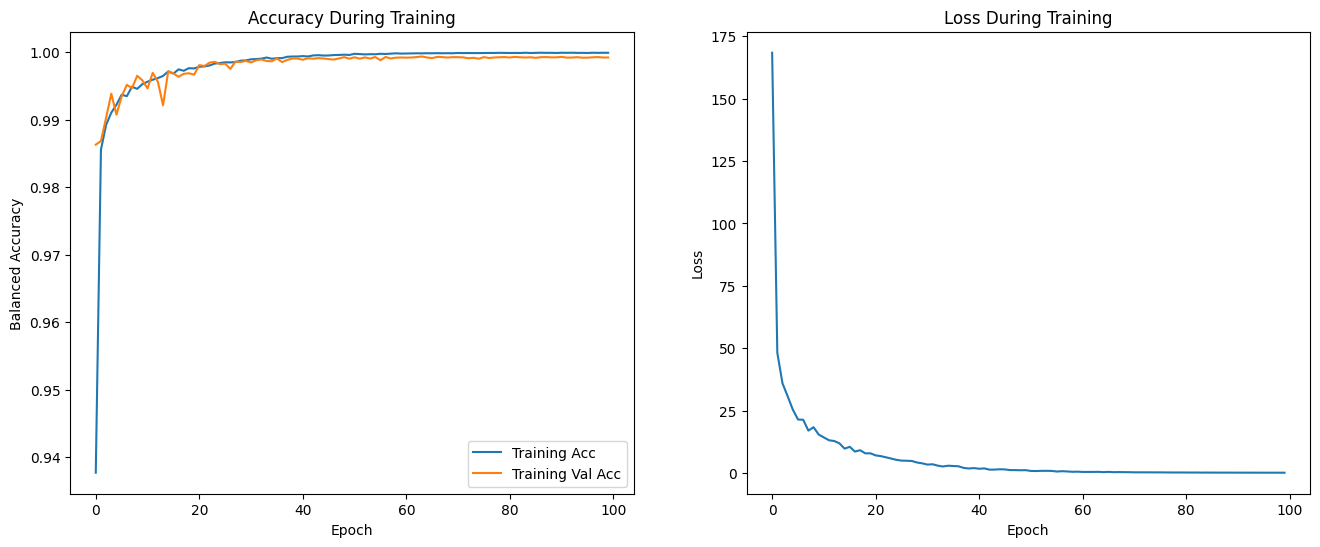

In [ ]:
TEMP_DIR = "/content/drive/MyDrive/CS131FinalProject/Models/f70eb372-b865-4733-a27b-31f930fe47f52024-03-03_00:33:26.147307"

# Graph Training
loss = np.load(os.path.join(TEMP_DIR, "loss.npy"))
train_acc = np.load(os.path.join(TEMP_DIR, "train_acc.npy"))
val_acc = np.load(os.path.join(TEMP_DIR, "val_acc.npy"))
epochs = np.arange(100)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Acc')
plt.plot(epochs, val_acc, label='Training Val Acc')
plt.title("Accuracy During Training")
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.title("Loss During Training")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Load test dataset
test_data, _, __, test_idxs = loadDataSet(TEMP_DIR, names=["train", "val", "test"])
sampler = SubsetRandomSampler(test_idxs)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, sampler=sampler)

In [ ]:
def getBestModel(dir):
  best_model = -1
  for file in os.listdir(dir):
    if str(file).isdigit(): best_model = max(best_model, int(file))
  return str(best_model)

In [ ]:
def update_acc(arr, output, labels, target):
  idxs = np.where(labels == target)[0]
  arr[0] += np.sum((output[idxs] == labels[idxs]).astype(int))
  arr[1] += idxs.shape[0]

In [ ]:
# Eval Model

# Load model and get predictions and labels
model = HandMLP()
checkpoint = torch.load(os.path.join(TEMP_DIR, getBestModel(TEMP_DIR)))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

x_acc, e_acc, o_acc = [0, 0], [0, 0], [0, 0]
for i, (input, label) in enumerate(test_loader):
  with torch.no_grad():
    label = label.numpy()
    output = model(input)
    output = np.argmin(output.numpy() * -1, axis=1)

    update_acc(x_acc, output, label, 0)
    update_acc(e_acc, output, label, 1)
    update_acc(o_acc, output, label, 2)

x_acc, e_acc, o_acc = x_acc[0]/x_acc[1], e_acc[0]/e_acc[1], o_acc[0]/o_acc[1]
print(x_acc, e_acc, o_acc)

0.9983628659476117 0.9997159359909099 0.9997176271266207


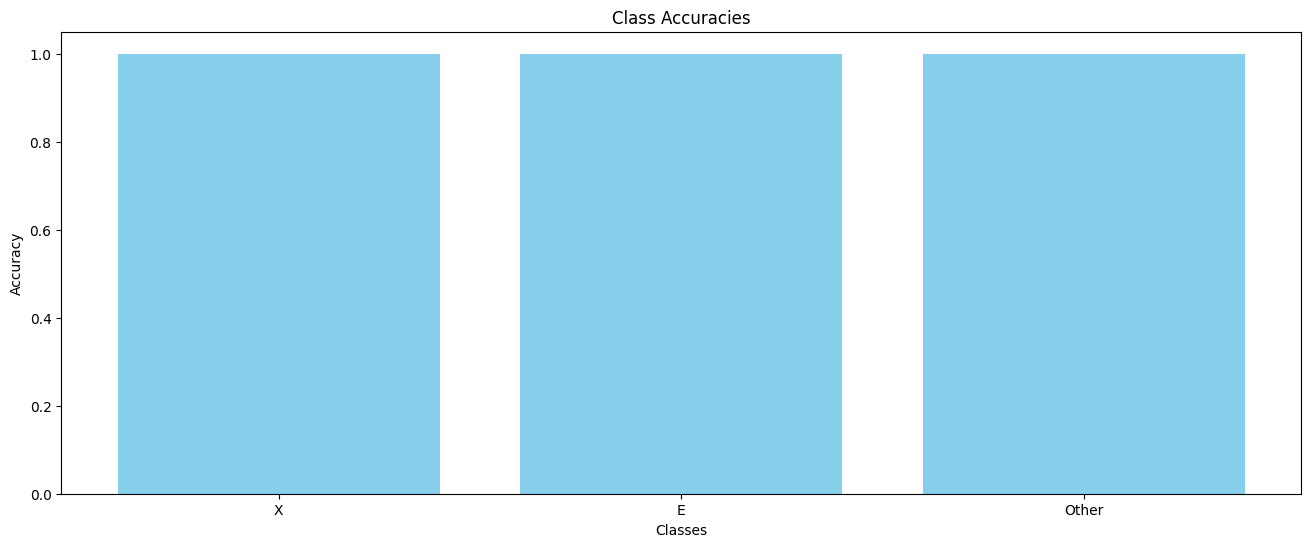

In [ ]:
# Create Histogram
categories = ['X', 'E', 'Other']
values = [x_acc, e_acc, o_acc]

plt.figure(figsize=(16, 6))
plt.bar(categories, values, color='skyblue')
plt.title('Class Accuracies')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Measure Average Inference time in ms on CPU

test_data = torch.from_numpy(x_data[0]).to(torch.float32)
model.eval()

for _ in range(TEST_WARMUP):
  with torch.no_grad():
    _ = model(test_data)

start_time = time.time()
for i in range(NUM_TESTS):
  with torch.no_grad():
    _ = model(test_data)

elapsed_time = time.time() - start_time
elapsed_time_ms = (elapsed_time * 1000) / NUM_TESTS

print(f"Average inference speed is {round(elapsed_time_ms, 3)}ms")

Average inference speed is 0.109ms
